# 6 methods to perform Time Series forecasting 
**From:** https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/

## Imports and install

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 


In [2]:
!pip install statsmodels

## Understanding the Problem Statement and Dataset

The dataset contain 2 years of data (2012-2014) at hourly level with the number of commuters travelling and we need to estimate the number of commuters for future.

In this notebook, we subsetting and aggregating dataset at daily basis to explain the different methods.

* Subsetting the dataset from (August 2012 – Dec 2013)
* Creating train and test file for modeling. The first 14 months (August 2012 – October 2013) are used as training data and next 2 months (Nov 2013 – Dec 2013) as testing data.
* Aggregating the dataset at daily basis

In [68]:
#Read dataset
#Index 11856 marks the end of year 2013
df = pd.read_csv('Data_train.csv', nrows = 11856)

#Aggregating the dataset at daily level
df['Timestamp'] = pd.to_datetime(df.Datetime, format='%d-%m-%Y %H:%M') 
df.index = df['Timestamp']
df = df.resample('D').mean()
df.tail()

ID       Count
Timestamp                      
2013-12-27  11747.5  161.166667
2013-12-28  11771.5  128.500000
2013-12-29  11795.5   97.083333
2013-12-30  11819.5  205.333333
2013-12-31  11843.5  202.500000

In [4]:
#Subsetting the dataset
#Creating train and test set 
#Oct2013 marks the end of October 2013 
test_date="2013-11-01"
for Oct2013, date in enumerate(df.index):
    if str(date)==test_date+" 00:00:00":
        break

train=df[:Oct2013]
test=df[Oct2013:]
display(train.tail())
display(test.head())

ID       Count
Timestamp                      
2013-10-27  10283.5   86.750000
2013-10-28  10307.5  147.333333
2013-10-29  10331.5  167.916667
2013-10-30  10355.5  157.250000
2013-10-31  10379.5  142.000000

ID       Count
Timestamp                      
2013-11-01  10403.5  161.583333
2013-11-02  10427.5  103.083333
2013-11-03  10451.5   76.833333
2013-11-04  10475.5  156.416667
2013-11-05  10499.5  169.750000

In [6]:
len(train), len(test)

(433, 61)

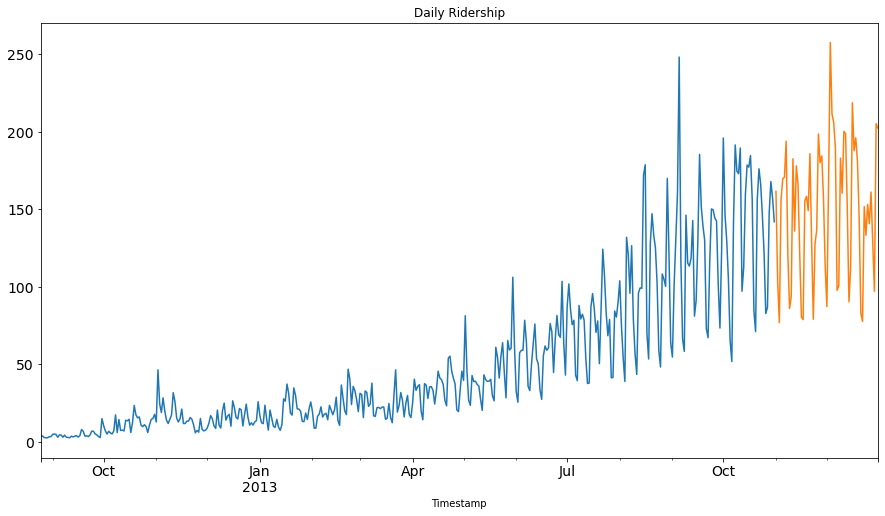

In [7]:
#Plotting data
train['Count'].plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test['Count'].plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show();

## Method 1: Naive Approach

It is assumed that the time series is stable and therefore the value to be predicted is equal to the previous value: $\hat{y}_{t+1}=y_t$

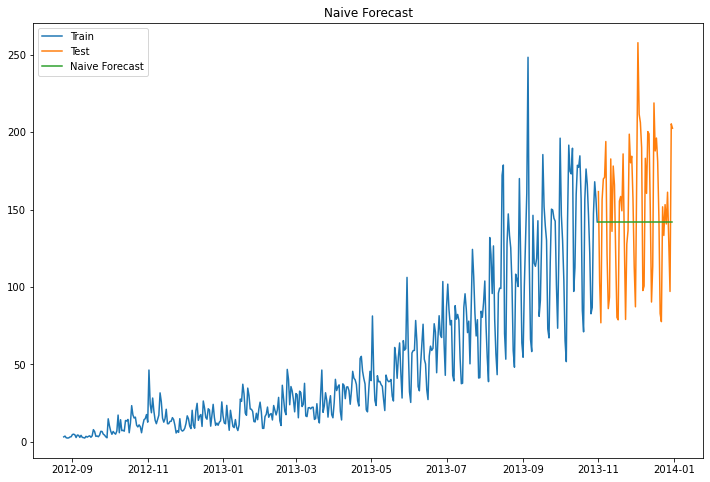

In [8]:
dd= np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show();

In [9]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test['Count'], y_hat['naive']))
print(rms)

43.91640614391676


## Method 2: Moving Average

It is assumed that the value to be predicted is the average of the previous days' values: $\hat{y}_{t+1}=\frac{1}{n}\sum_{i=0}^{n-1}y_{t-i}$

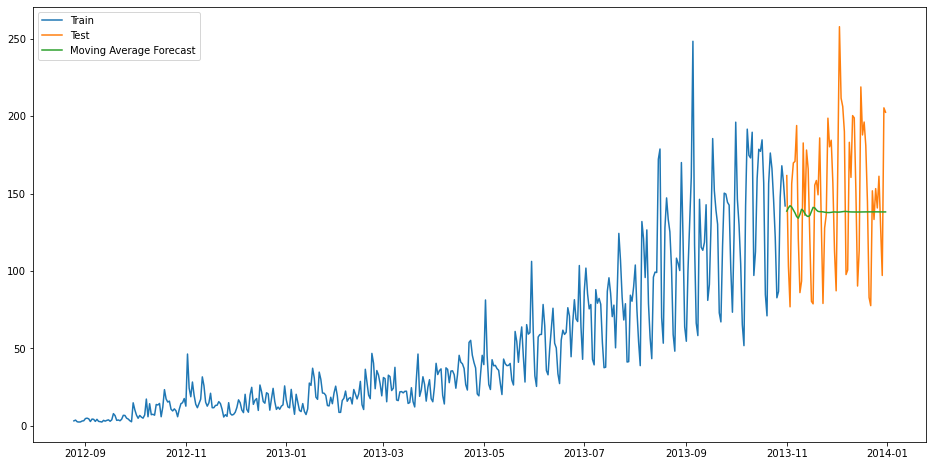

In [10]:
sliding_window = 20

pred=train['Count'][-sliding_window:].tolist()
for i in range(len(test)):
    pred.append(np.mean(pred[-sliding_window:]))
    
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = pred[sliding_window:]

plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show();

In [11]:
rms = sqrt(mean_squared_error(test['Count'], y_hat_avg['moving_avg_forecast']))
print(rms)

44.969691799261845


A more simple approach is considering all future values are the mean of the know previous days.: $\hat{y}_{t+1, t+2, ...}=\frac{1}{n}\sum_{i=0}^{n-1}y_{t-i}$

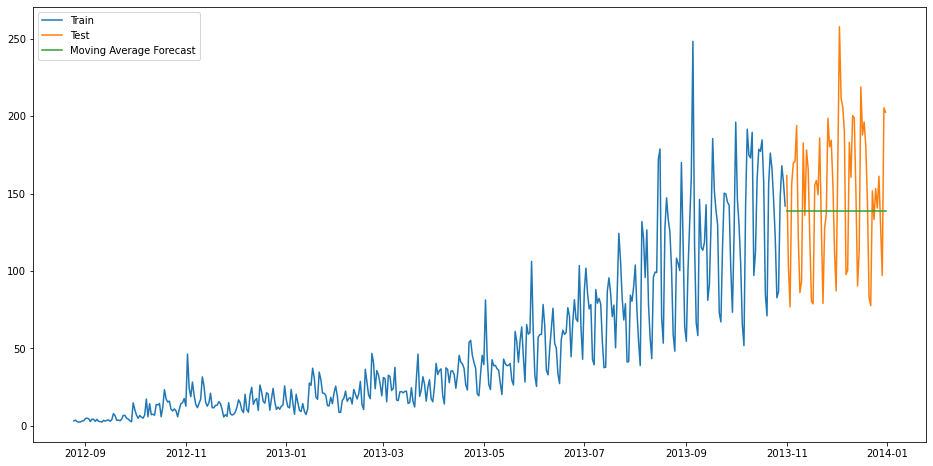

In [13]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(sliding_window).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show();

In [14]:
rms = sqrt(mean_squared_error(test['Count'], y_hat_avg['moving_avg_forecast']))
print(rms)

44.59986528941813


## Method 3: Simple Exponential Smoothing

An advance over the moving average method or not is to **add a weight** to past observations: $\hat{y}_{t+1}=\frac{1}{n}\sum_{i=0}^{n-1}w_{t-1}*y_{t-i}$

The question is how to adjust the series of weights. The method generally taken consists in constructing this one starting from a coefficient $\alpha$ in the following way: $W = [\alpha, \alpha*(1-\alpha), \alpha*(1-\alpha)^2, ...]$ where $0≤ \alpha ≤1$ is the smoothing parameter.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


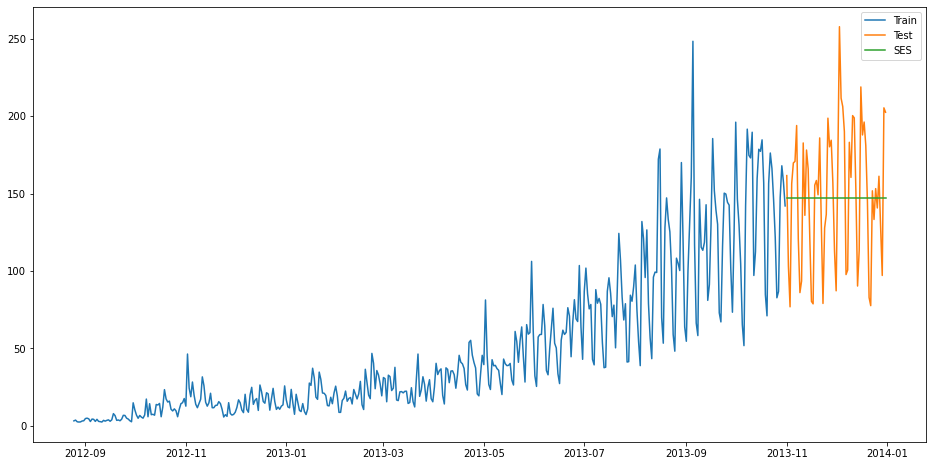

In [15]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6, optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show();

In [16]:
rms = sqrt(mean_squared_error(test['Count'], y_hat_avg['SES']))
print(rms)

43.357625225228155


We can see that implementing Simple exponential model with alpha as 0.6 generates a better model till now. We can tune the parameter using the validation set to generate even a better Simple exponential model.

## Method 4: Holt’s Linear Trend method

We have now learned several forecasting methods, but we are finding that these models do not work well on highly variable data. 

We need a method that can accurately map the trend without any assumptions. Such a method that takes into account the trend of the dataset is called the **Holt linear trend method**.

Each time series of data can be decomposed into its components which are the trend, seasonality and residual. Any data set that follows a trend can use the **Holt linear trend method** for forecasting.



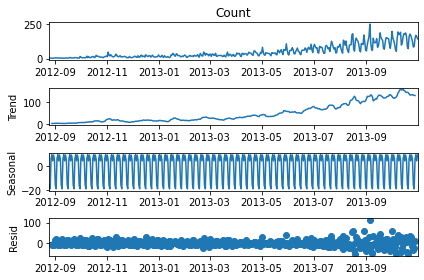

In [17]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train['Count']).plot()
result = sm.tsa.stattools.adfuller(train['Count'])
plt.show();

The resulting graphs show that this data set is on an upward trend. We can therefore use **Holt's linear trend** to forecast future prices.

Holt has extended simple exponential smoothing to allow the data to be forecast with a trend. This is simply exponential smoothing applied to both the level (the mean value of the series) and the trend. To express this in mathematical notation, we now need three equations: one for the level, one for the trend, and one to combine the level and the trend to obtain the expected forecast $\hat{y}$.

* Level equation: $l_t = \alpha * y_t + (1-\alpha)(l_{t-1}+b_{t-1})$
* Trend equation: $b_t = \beta * (l_t - l_{t-1}) + (1 - \beta) * b_{t-1}$
* Forecast equation: $\hat{y}_{t+h|t}= l_t + h * b_t$

The trend equation shows that it is a weighted average of the estimated trend at time t, based on $(l_t - l_{t-1})$ and $b_{t-1}$, the previous estimate of the trend.

We can also generate a multiplicative forecast equation by multiplying the trend and the level instead of adding them together:
* when the trend increases or decreases linearly, we use an additive equation,
* while when the trend increases or decreases exponentially, we use a multiplicative equation.

Practice shows that the multiplicative method is a more stable predictor, but the additive method is simpler to understand.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  This is separate from the ipykernel package so we can avoid doing imports until


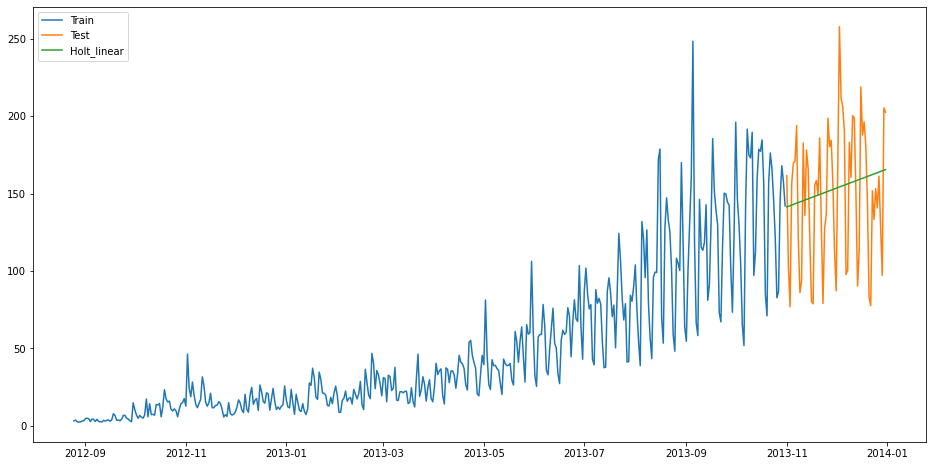

In [18]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [19]:
rms = sqrt(mean_squared_error(test['Count'], y_hat_avg['Holt_linear']))
print(rms)

43.056259611507286


## Method 5: Holt-Winters Method

The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices. One such algorithm that we can use in such a scenario is **Holt’s Winter method**. The idea behind triple exponential smoothing(Holt’s Winter) is to apply exponential smoothing to the seasonal components in addition to level and trend.

Using Holt’s winter method will be the best option among the rest of the models because of the seasonality factor. The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations — one for the level $L_t$, one for trend $b_t$ and one for the seasonal component denoted by $S_t$, with smoothing parameters $\alpha$, $\beta$ and $\gamma$.

* Level equation: $L_t = \alpha * (y_t - S_{t-s}) + (1-\alpha)(L_{t-1} + b_{t-1})$
* Trend equation: $b_t = \beta * (L_t - L_{t-1}) + (1 - \beta) * b_{t-1}$
* Seasonnal equation: $S_t = \gamma * (y_t - L_t) + (1 - \gamma) * S_{t-s})$
* Forecast equation: $F_{t+k} = L_t + k * b_t + S_{t+k-s}$

where $s$ is the length of the seasonal cycle, for $0 ≤ \alpha ≤ 1$, $0 ≤ \beta ≤ 1$ and $0 ≤ \gamma ≤ 1$.


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


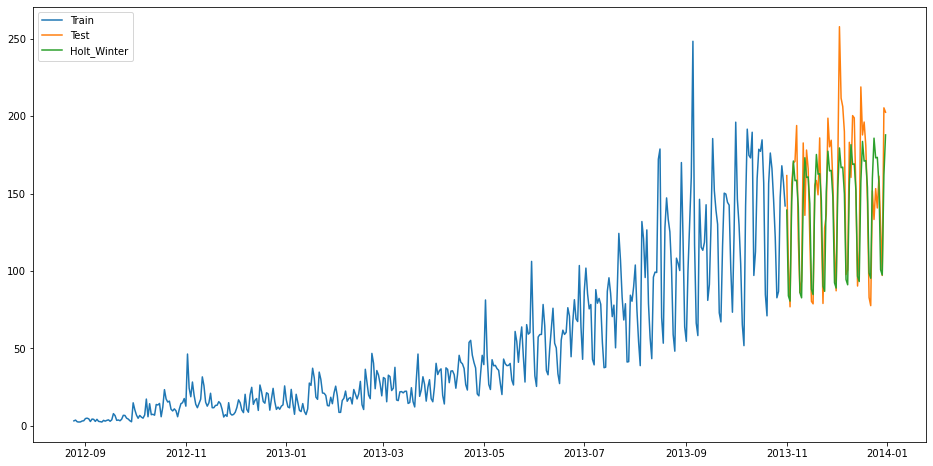

In [20]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Count']),seasonal_periods=7 ,trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show();

In [21]:
rms = sqrt(mean_squared_error(test['Count'], y_hat_avg['Holt_Winter']))
print(rms)

25.26467078546034


## Method 6: ARIMA

ARIMA is another time series model that is very popular among Data scientists. It stands for **"AutoRegressive Integrated Moving Average"**. While exponential smoothing models were based on a description of the trend and seasonality of the data, ARIMA models aim to describe the correlations of the data with each other. An improvement over ARIMA is the seasonal ARIMA model. It takes into account the seasonality of the data set, as does the Holt' Winter method.

The general steps to implement an ARIMA model are:

* **Load the data:** The first step for model building is of course to load the dataset
* **Preprocessing:** Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
* **Make series stationary:** In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
* **Determine d value:** For making the series stationary, the number of times the difference operation was performed will be taken as the d value
* **Create ACF and PACF plots:** This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
* **Determine the p and q values:** Read the values of p and q from the plots in the previous step
* **Fit ARIMA model:** Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
* **Predict values on validation set:** Predict the future values
* **Calculate RMSE:** To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set

### Parameter tuning for ARIMA model

First of all we have to make sure that the time series is stationary. If the series is not stationary, we will make it stationary.

The Dickey Fuller test verifies the stationarity of the series. The intuition behind this test is that it determines the strength with which a time series is defined by a trend. The null hypothesis of the test is that the time series is not stationary (has a certain time-dependent structure). The other assumption (rejecting the null hypothesis) is that the time series is stationary.

The test results include a test statistic and some critical values for the confidence levels of the differences. If the "test statistic" is less than the "critical value", we can reject the null hypothesis and say that the series is stationary.

Let’s make a function which we can use to calculate the results of Dickey-Fuller test.

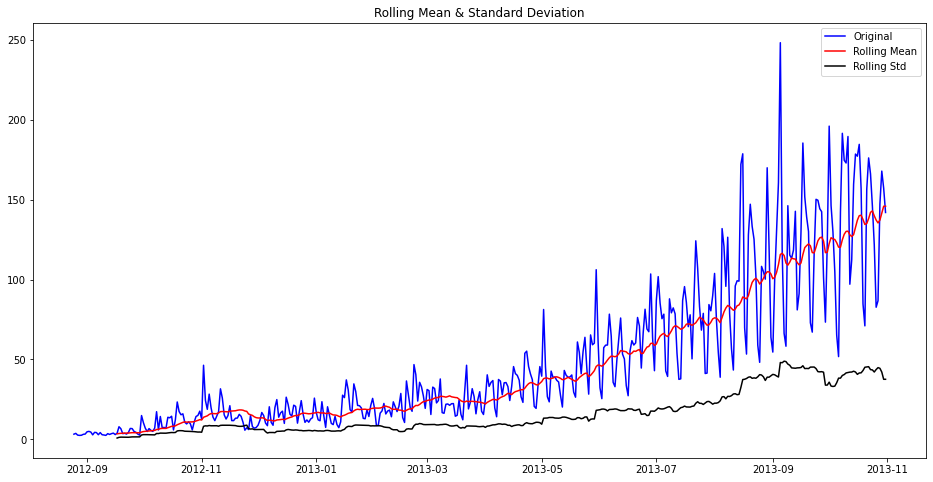

Results of Dickey-Fuller Test:
Test Statistic                   0.306586
p-value                          0.977645
#Lags Used                      16.000000
Number of Observations Used    416.000000
Critical Value (1%)             -3.446168
Critical Value (5%)             -2.868513
Critical Value (10%)            -2.570484
dtype: float64


In [22]:
from statsmodels.tsa.stattools import adfuller 

def test_stationarity(timeseries):
        #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=24).mean() # 24 hours on each day
    rolstd = pd.Series(timeseries).rolling(window=24).std()
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 16, 8
test_stationarity(train['Count'])

The statistics show that the time series is stationary as *Test Statistic < critical value* but an upward trend can be seen in the data. So first we will try to make the data more stationary. To do this we need to remove the trend and seasonality from the data.

Nevertheless, we can see an upward trend. We'll try to make the data more stationary. To do this we need to remove the trend and seasonality from the data.

#### Removing Trend

* A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.

* We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example log transformation.

* We will take rolling average here to remove the trend. We will take the window size of 24 based on the fact that each day has 24 hours.

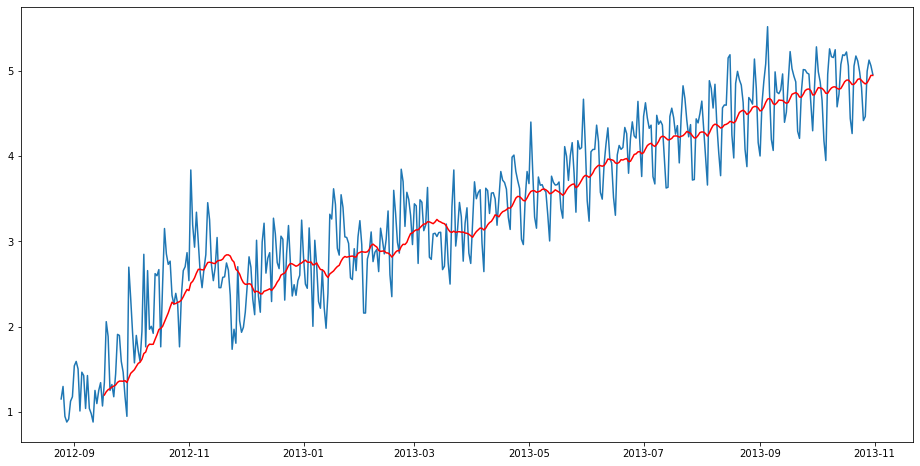

In [44]:
train_log = np.log(train['Count']) 
#valid_log = np.log(valid['Count'])
moving_avg = pd.Series(train_log).rolling(window=24).mean() 
plt.plot(train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show();

Now we will remove this increasing trend to make our time series stationary.

Since we took the average of 24 values, rolling mean is not defined for the first 23 values. So let’s drop those null values.

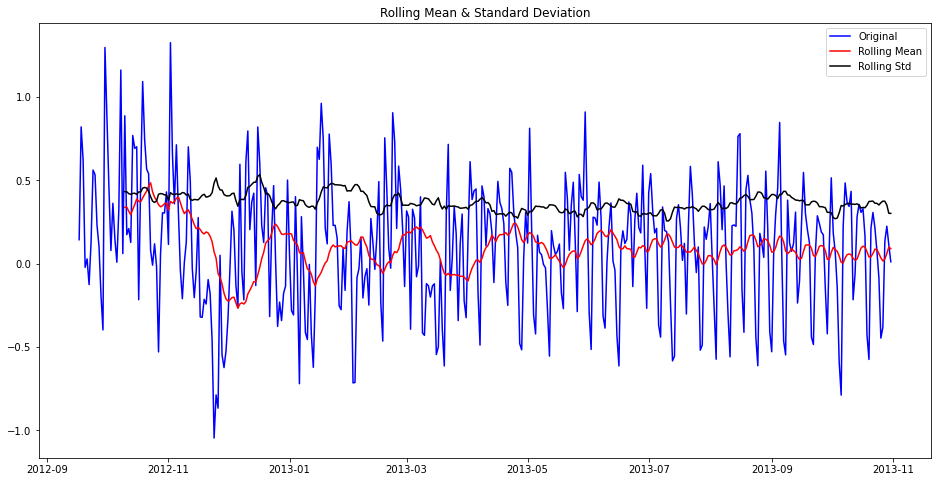

Results of Dickey-Fuller Test:
Test Statistic                  -5.561408
p-value                          0.000002
#Lags Used                      16.000000
Number of Observations Used    393.000000
Critical Value (1%)             -3.447099
Critical Value (5%)             -2.868923
Critical Value (10%)            -2.570703
dtype: float64


In [45]:
train_log_moving_avg_diff = train_log - moving_avg
train_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(train_log_moving_avg_diff)

We can see that the Test Statistic is very smaller as compared to the Critical Value. So, we can be confident that the trend is almost removed.

Let’s now stabilize the mean of the time series which is also a requirement for a stationary time series.

Differencing can help to make the series stable and eliminate the trend.


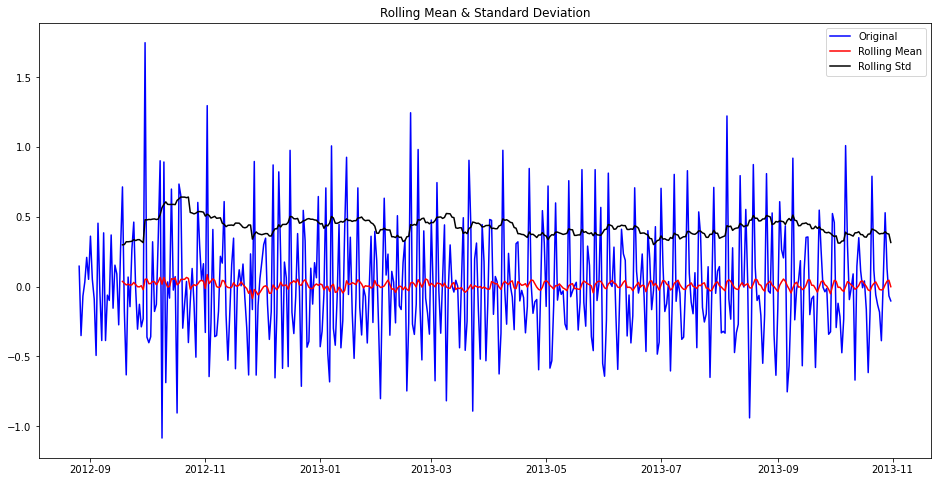

Results of Dickey-Fuller Test:
Test Statistic                -7.182089e+00
p-value                        2.633764e-10
#Lags Used                     1.400000e+01
Number of Observations Used    4.170000e+02
Critical Value (1%)           -3.446129e+00
Critical Value (5%)           -2.868496e+00
Critical Value (10%)          -2.570475e+00
dtype: float64


In [46]:
train_log_diff = train_log - train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

Now we will decompose the time series into trend and seasonality and will get the residual which is the random variation in the series.

#### Removing Seasonality

* By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).
* Seasonality is always of a fixed and known period.
* We will use seasonal decompose to decompose the time series into trend, seasonality and residuals.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


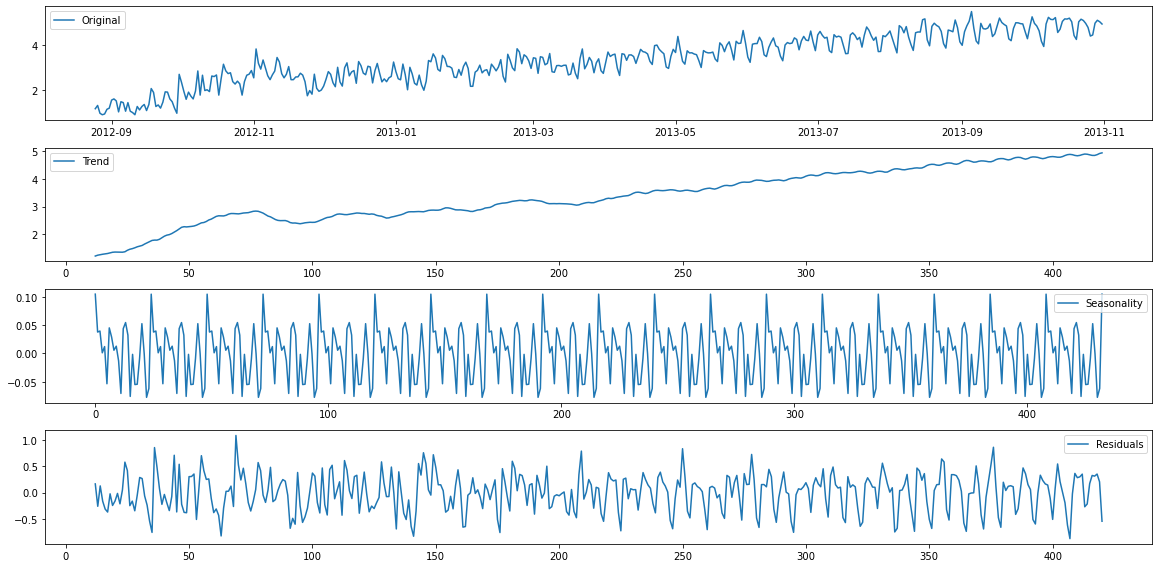

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(pd.DataFrame(train_log).Count.values, freq = 24) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.subplot(411) 
plt.plot(train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show();

We can see the trend, residuals and the seasonality clearly in the above graph. Seasonality shows a constant trend in counter.

Let’s check stationarity of residuals.

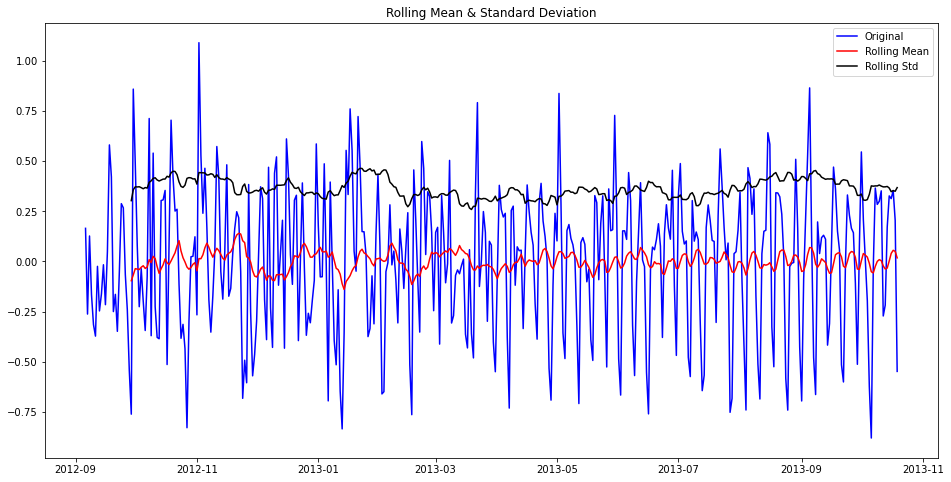

Results of Dickey-Fuller Test:
Test Statistic                -6.854748e+00
p-value                        1.659424e-09
#Lags Used                     1.600000e+01
Number of Observations Used    3.920000e+02
Critical Value (1%)           -3.447142e+00
Critical Value (5%)           -2.868941e+00
Critical Value (10%)          -2.570713e+00
dtype: float64


In [48]:
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = train_log.index 
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])

The result can be interpreted from the results that the residuals are stationary.

Now we will forecast the time series using different models.


### Forecasting the time series using ARIMA

* First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the p,d,q parameters.

* To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

* ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.

* PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [49]:
from statsmodels.tsa.stattools import acf, pacf 

lag_acf = acf(train_log_diff.dropna(), nlags=20) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=20, method='ols')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:669: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


#### ACF and PACF plot

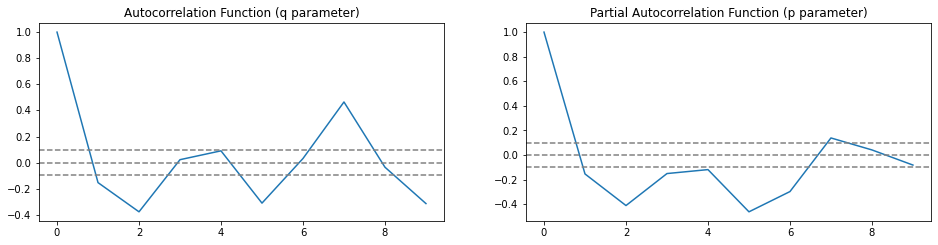

In [51]:
plt.subplot(2,2,1)
plt.plot(lag_acf[:10]) 
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function (q parameter)') 
#plt.show() 
plt.subplot(2,2,2)
plt.plot(lag_pacf[:10]) 
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function (p parameter)') 
plt.show()

* q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=1 (remember the first value is for index 0).
* p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=1 (remember the first value is for index 0).
* Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA model separately and then combine them together.

#### AR model

The autoregressive model specifies that the output variable depends linearly on its own previous values.

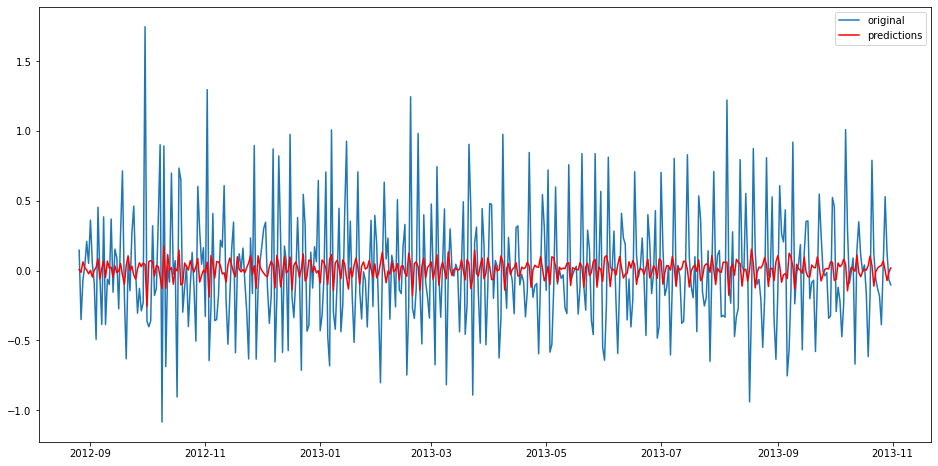

In [86]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_log, order=(1, 1, 0))
    # here the q value is zero since it is just the AR model 
    # and p is equal to 1
results_AR = model.fit()  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show();

Lets plot the validation curve for AR model (we use here test set).

We have to change the scale of the model to the original scale.

First step would be to store the predicted results as a separate series and observe it.

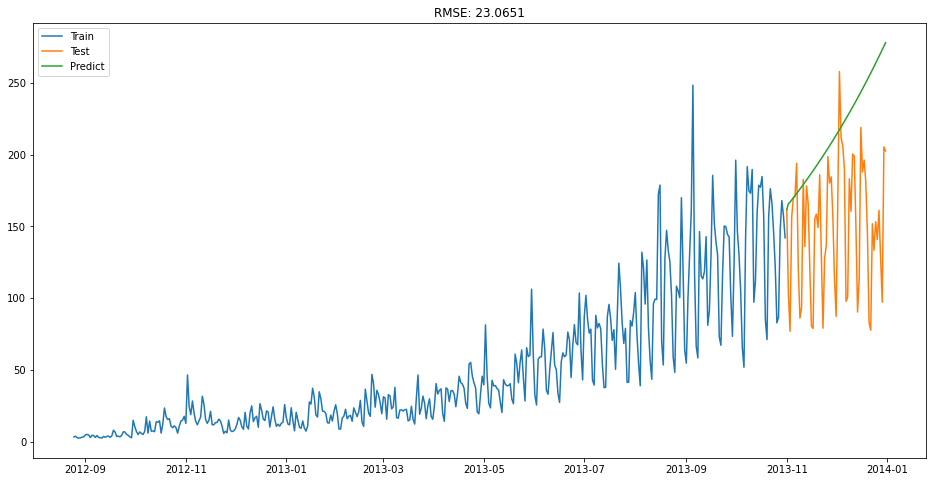

In [91]:
end_date = '2013-12-31'

AR_predict = results_AR.predict(start=test_date,end=end_date)
AR_predict = AR_predict.cumsum().shift().fillna(0)

AR_predict1 = pd.Series(np.ones(len(test)) * np.log(test['Count'])[0], index = test.index) 
AR_predict1 = AR_predict1.add(AR_predict,fill_value=0) 

AR_predict = np.exp(AR_predict1)

plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label = "Test") 
plt.plot(AR_predict, label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, test['Count']))/len(test)))
plt.show();

Here the red line shows the prediction for the validation set. Let’s build the MA model now.

#### MA model

The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.


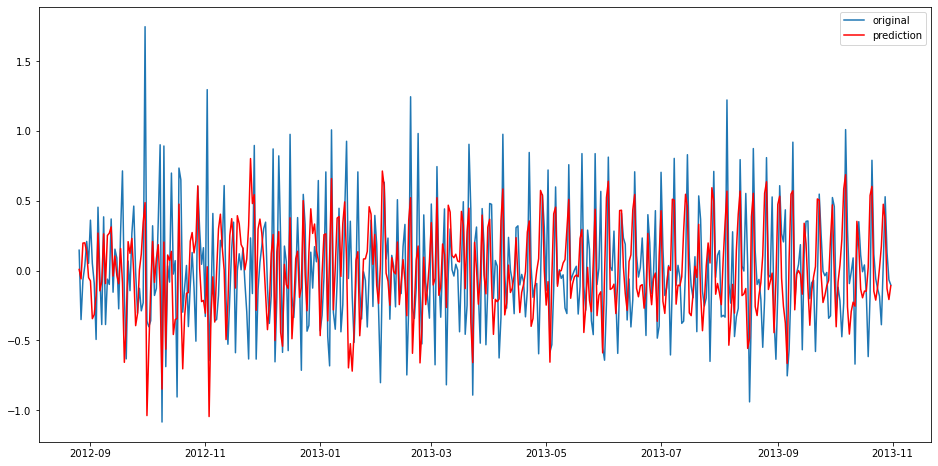

In [88]:
model = ARIMA(train_log, order=(0, 1, 1)) 
    # here the p value is zero since it is just the MA model 
    # and q is egual to 2
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show();

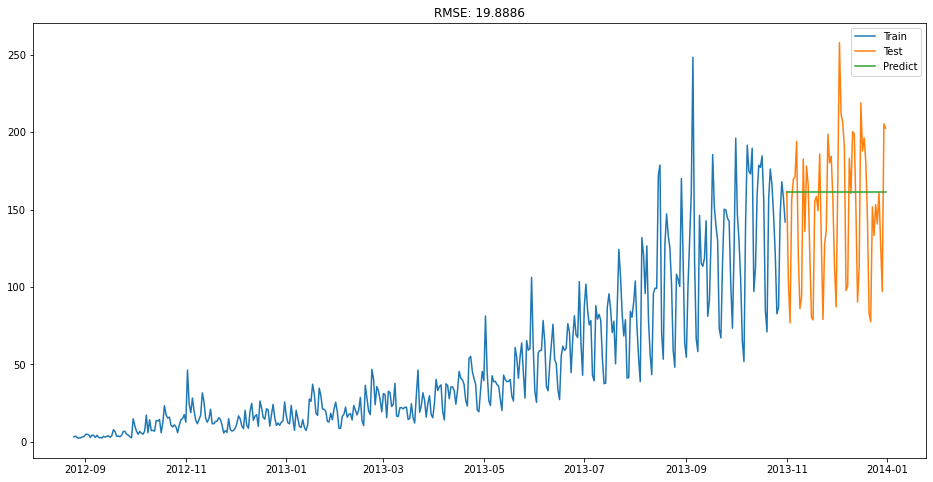

In [92]:
MA_predict = results_MA.predict(start=test_date,end=end_date)
MA_predict = MA_predict.cumsum().shift().fillna(0)

MA_predict1 = pd.Series(np.ones(len(test)) * np.log(test['Count'])[0], index = test.index) 
MA_predict = MA_predict.add(AR_predict,fill_value=0) 

MA_predict = np.exp(MA_predict1)

plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label = "Test") 
plt.plot(MA_predict, label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, test['Count']))/len(test)))
plt.show();

Now let’s combine these two models.

#### Combined model

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


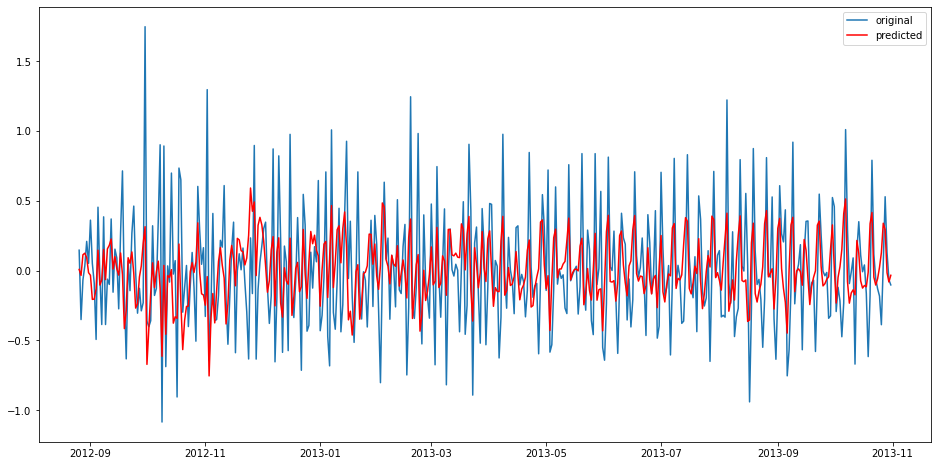

In [106]:
model = ARIMA(train_log, order=(1, 1, 1))
    # fix p and q
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show();

Let’s define a function which can be used to change the scale of the model to the original scale.

In [107]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(train['Count'], label='Train')
    plt.plot(given_set['Count'], label = "Test")
    plt.plot(predict, label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
     
    plt.plot(train['Count'], label='Train')
    plt.plot(given_set['Count'], label = "Test")
    plt.plot(predict, label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()


Let’s predict the values for validation set.

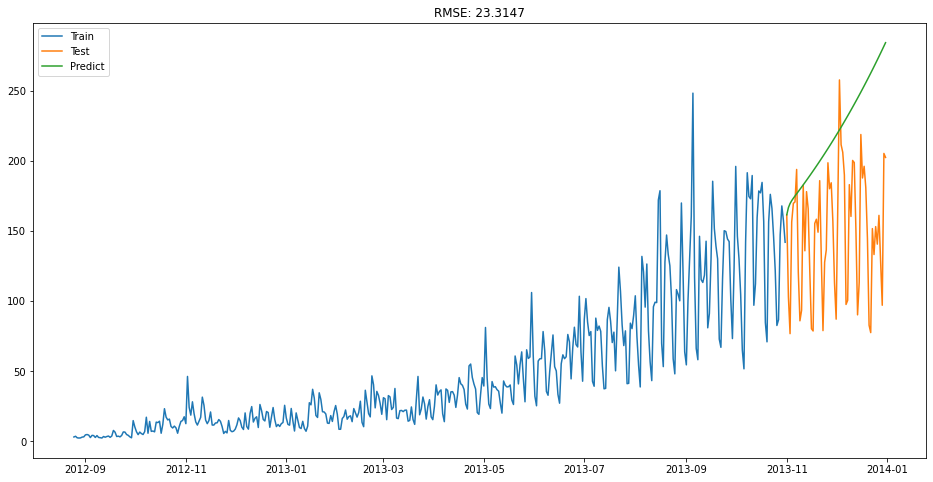

In [108]:
ARIMA_predict_diff=results_ARIMA.predict(start=test_date,end=end_date)
check_prediction_diff(ARIMA_predict_diff, test)

### SARIMAX model on daily time series

SARIMAX model takes into account the seasonality of the time series. In the above model :
* **order:** The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include.
* **seasonal order:** The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. s is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


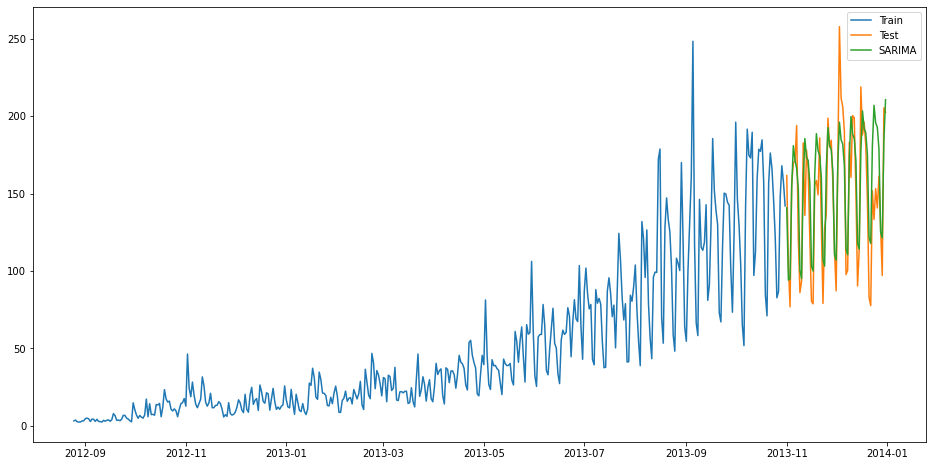

In [101]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train['Count'], order=(2, 1, 4), seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2013-11-1", end="2013-12-31", dynamic=True)

plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show();

In [109]:
rms = sqrt(mean_squared_error(test['Count'], y_hat_avg['SARIMA']))
print(rms)

26.05516939645797


We can see that the use of Seasonal ARIMA generates a solution similar to Holt's Winter.

The main difficulty is to set the different parameters correctly. There is a framework in Python that allows to determine the optimal parameters of the model: [auto.arima](https://github.com/tgsmith61591/pyramid)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-install" data-toc-modified-id="Imports-and-install-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and install</a></span></li><li><span><a href="#Understanding-the-Problem-Statement-and-Dataset" data-toc-modified-id="Understanding-the-Problem-Statement-and-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Understanding the Problem Statement and Dataset</a></span></li><li><span><a href="#Method-1:-Naive-Approach" data-toc-modified-id="Method-1:-Naive-Approach-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method 1: Naive Approach</a></span></li><li><span><a href="#Method-2:-Simple-Average" data-toc-modified-id="Method-2:-Simple-Average-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Method 2: Simple Average</a></span></li><li><span><a href="#Method-3:-Simple-Exponential-Smoothing" data-toc-modified-id="Method-3:-Simple-Exponential-Smoothing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Method 3: Simple Exponential Smoothing</a></span></li><li><span><a href="#Method-4:-Holt’s-Linear-Trend-method" data-toc-modified-id="Method-4:-Holt’s-Linear-Trend-method-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Method 4: Holt’s Linear Trend method</a></span></li><li><span><a href="#Method-5:-Holt-Winters-Method" data-toc-modified-id="Method-5:-Holt-Winters-Method-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Method 5: Holt-Winters Method</a></span></li><li><span><a href="#Method-5:-ARIMA" data-toc-modified-id="Method-5:-ARIMA-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Method 5: ARIMA</a></span><ul class="toc-item"><li><span><a href="#Parameter-tuning-for-ARIMA-model" data-toc-modified-id="Parameter-tuning-for-ARIMA-model-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Parameter tuning for ARIMA model</a></span><ul class="toc-item"><li><span><a href="#Removing-Trend" data-toc-modified-id="Removing-Trend-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>Removing Trend</a></span></li><li><span><a href="#Removing-Seasonality" data-toc-modified-id="Removing-Seasonality-8.1.2"><span class="toc-item-num">8.1.2&nbsp;&nbsp;</span>Removing Seasonality</a></span></li></ul></li><li><span><a href="#Forecasting-the-time-series-using-ARIMA" data-toc-modified-id="Forecasting-the-time-series-using-ARIMA-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Forecasting the time series using ARIMA</a></span><ul class="toc-item"><li><span><a href="#ACF-and-PACF-plot" data-toc-modified-id="ACF-and-PACF-plot-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>ACF and PACF plot</a></span></li><li><span><a href="#AR-model" data-toc-modified-id="AR-model-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>AR model</a></span></li><li><span><a href="#MA-model" data-toc-modified-id="MA-model-8.2.3"><span class="toc-item-num">8.2.3&nbsp;&nbsp;</span>MA model</a></span></li><li><span><a href="#Combined-model" data-toc-modified-id="Combined-model-8.2.4"><span class="toc-item-num">8.2.4&nbsp;&nbsp;</span>Combined model</a></span></li></ul></li><li><span><a href="#SARIMAX-model-on-daily-time-series" data-toc-modified-id="SARIMAX-model-on-daily-time-series-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>SARIMAX model on daily time series</a></span></li></ul></li></ul></div>